In [1]:
#Import all the necessary libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import copy
import warnings
import matplotlib.patches as patches
from pathlib import Path
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from torch.utils.data import TensorDataset, DataLoader

# Functions

In [2]:
#This function evaluates the specific angular coefficients at given energy value

def Y(energy, f_mode):
    Y = torch.zeros((4, 1))

    #Convert Energy to PeV
    xe = .5 + 20 * (torch.log(energy) - log_01) / (log_10 - log_01)
    xe2 = xe * xe

    #Evaluate Y for given energy and mode
    for i in range(4):
        if f_mode == "mg0":
            Y[i] = torch.exp(PXmg_p[i, 0, 0]) + torch.exp(PXmg_p[i ,0, 1] * torch.pow(xe, PXmg_p[i, 0, 2]))

        elif f_mode == "mg2":
            Y[i] = PXmg_p[i, 2, 0] + PXmg_p[i, 2, 1] * xe + PXmg_p[i, 2, 2] * xe2

        elif f_mode == "eg0":
            Y[i] = PXeg_p[i, 0, 0] * torch.exp(PXeg_p[i, 0, 1] * torch.pow(xe, PXeg_p[i, 0, 2]))

        elif f_mode == "eg1":
            Y[i] = PXeg_p[i, 1, 0] + PXeg_p[i, 1, 1] * xe + PXeg_p[i, 1, 2] * xe2

        elif f_mode == "eg2":
            Y[i] = PXeg_p[i, 2, 0] + PXeg_p[i, 2, 1] * xe + PXeg_p[i, 2, 2] * xe2

        elif f_mode == "mp0":
            Y[i] = torch.exp(PXmp_p[i, 0, 0]) + torch.exp(PXmp_p[i, 0, 1] * torch.pow(xe, PXmp_p[i, 0, 2]))

        elif f_mode == "mp2":
            Y[i] = PXmp_p[i, 2, 0] + PXmp_p[i, 2, 1] * xe + PXmp_p[i, 2, 2] * xe2

        elif f_mode == "ep0":
            Y[i] = torch.exp(PXep_p[i, 0, 0]) + torch.exp(PXep_p[i, 0, 1] * torch.pow(xe, PXep_p[i, 0, 2]))

        elif f_mode == "ep1":
            Y[i] = PXep_p[i, 1, 0] + PXep_p[i, 1, 1] * xe + PXep_p[i, 1, 2] * xe2

        elif f_mode == "ep2":
            Y[i] = PXep_p[i, 2, 0] + PXep_p[i, 2, 1] * xe + PXep_p[i, 2, 2] * xe2

        else:
            warnings.warn("The Mode is not defined")
            return

    return Y

In [3]:
#Interpolated parameter computation
#thisp0 = normalization constant
#thisp1 = slope parameter
#thisp2 = shape parameter

def thisp(energy, theta, f_mode):
    #Find Y values
    Y_val = Y(energy, f_mode)

    #Solve for B
    B = torch.linalg.solve(A, Y_val)

    #Define x from theta
    x = .5 + 4 * theta / theta_max

    res = 0

    for i in range(4):
        res += B[i] * x ** i

    return res

In [4]:
def ReadShowers(path_g, path_p):
    #GAMMA SHOWERS
    #Reading the Electron Parameters in the Showers
    PXeg1_p = np.loadtxt(path_g, max_rows = 3)

    for i in range(3):
        if PXeg1_p[i, 0]*PXeg1_p[i, 1]*PXeg1_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXeg2_p = np.loadtxt(path_g, skiprows = 3, max_rows = 3)
    
    for i in range(3):
        if PXeg2_p[i, 0]*PXeg2_p[i, 1]*PXeg2_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXeg3_p = np.loadtxt(path_g, skiprows = 6, max_rows = 3)
    
    for i in range(3):
        if PXeg3_p[i, 0]*PXeg3_p[i, 1]*PXeg3_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXeg4_p = np.loadtxt(path_g, skiprows = 9, max_rows = 3)
    
    for i in range(3):
        if PXeg4_p[i, 0]*PXeg4_p[i, 1]*PXeg4_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return
            
    #Reading the Muon Parameters in the Showers
    PXmg1_p = np.loadtxt(path_g, skiprows = 12, max_rows = 3)
    
    for i in range(3):
        if PXmg1_p[i, 0]*PXmg1_p[i, 1]*PXmg1_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return
            
    PXmg2_p = np.loadtxt(path_g, skiprows = 15, max_rows = 3)
    
    for i in range(3):
        if PXmg2_p[i, 0]*PXmg2_p[i, 1]*PXmg2_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmg3_p = np.loadtxt(path_g, skiprows = 18, max_rows = 3)
    
    for i in range(3):
        if PXmg3_p[i, 0]*PXmg3_p[i, 1]*PXmg3_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmg4_p = np.loadtxt(path_g, skiprows = 21, max_rows = 3)
    
    for i in range(3):
        if PXmg4_p[i, 0]*PXmg4_p[i, 1]*PXmg4_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    #PROTON SHOWERS
    #Reading the Electron Parameters in the Showers
    PXep1_p = np.loadtxt(path_p, max_rows = 3)

    for i in range(3):
        if PXep1_p[i, 0]*PXep1_p[i, 1]*PXep1_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXep2_p = np.loadtxt(path_p, skiprows = 3, max_rows = 3)
    
    for i in range(3):
        if PXep2_p[i, 0]*PXep2_p[i, 1]*PXep2_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXep3_p = np.loadtxt(path_p, skiprows = 6, max_rows = 3)
    
    for i in range(3):
        if PXep3_p[i, 0]*PXep3_p[i, 1]*PXep3_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return

    PXep4_p = np.loadtxt(path_p, skiprows = 9, max_rows = 3)
    
    for i in range(3):
        if PXep4_p[i, 0]*PXep4_p[i, 1]*PXep4_p[i, 2] == 0:
            warnings.warn("Encountered 0")
            return
            
    #Reading the Muon Parameters in the Showers
    PXmp1_p = np.loadtxt(path_p, skiprows = 12, max_rows = 3)
    
    for i in range(3):
        if PXmp1_p[i, 0]*PXmp1_p[i, 1]*PXmp1_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmp2_p = np.loadtxt(path_p, skiprows = 15, max_rows = 3)
    
    for i in range(3):
        if PXmp2_p[i, 0]*PXmp2_p[i, 1]*PXmp2_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmp3_p = np.loadtxt(path_p, skiprows = 18, max_rows = 3)
    
    for i in range(3):
        if PXmp3_p[i, 0]*PXmp3_p[i, 1]*PXmp3_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmp4_p = np.loadtxt(path_p, skiprows = 21, max_rows = 3)
    
    for i in range(3):
        if PXmp4_p[i, 0]*PXmp4_p[i, 1]*PXmp4_p[i, 2] == 0 and i != 1:
            warnings.warn("Encountered 0")
            return

    PXmg_p = torch.tensor([PXmg1_p, PXmg2_p, PXmg3_p, PXmg4_p])
    PXeg_p = torch.tensor([PXeg1_p, PXeg2_p, PXeg3_p, PXeg4_p])
    PXmp_p = torch.tensor([PXmp1_p, PXmp2_p, PXmp3_p, PXmp4_p])
    PXep_p = torch.tensor([PXep1_p, PXep2_p, PXep3_p, PXep4_p])

    return PXmg_p, PXeg_p, PXmp_p, PXep_p

In [5]:
#This function parametrize the particle species content from the showers
#We find the flux of the particles for a given energy, angle and distance
#f_mode is used to tell the code which particle species we are dealing with, beacuse equation changes
#whether we are dealing with muons or electrons

def ShowerContent(energy, theta, R, f_mode):
    #Check if everything is in the range:
    R = torch.clamp(R, min=R_min)

    if energy < .1 or energy > 10:
        warnings.warn("Energy is out of range!")
        return 0

    if theta < 0 or theta > theta_max:
        warnings.warn("Angle is out of range!")
        return 0
    
    if f_mode == "mg" or f_mode == "mp":
        thisp0 = thisp(energy, theta, f_mode + "0")
        thisp2 = thisp(energy, theta, f_mode + "2")
        
        #Evaluate the  Flux
        flux0 = TankArea * .02 * thisp0 * torch.exp(-1 * torch.pow(R, thisp2))

    elif f_mode == "eg" or f_mode == "ep":
        thisp0 = thisp(energy, theta, f_mode + "0")
        thisp1 = thisp(energy, theta, f_mode + "1")
        thisp2 = thisp(energy, theta, f_mode + "2")
        
        #Evaluate the Flux
        flux0 = TankArea * thisp0 * torch.exp(-thisp1 * torch.pow(R, thisp2))

    else:
        warnings.warn("Mode is not defined")
        return

    #We need to make sure that flux is non negative or too large
    flux0 = torch.clamp(flux0, min=epsilon, max=largenumber)

    return flux0

In [6]:
#This function defines the initial layouts of the detectors, N_det = 4000
#At this point of the project, we just define a square grid

def Layouts():
    R = [50, 200, 350, 550, 750, 1000]
    x = []
    y = []

    for i, r in enumerate(R):
        if i == 0:
            for j in range(3):
                x.append(r * np.cos(j *np.pi * 2 / 3))
                y.append(r * np.sin(j *np.pi * 2 / 3))

        if i == 1:
            for j in range(9):
                x.append(r * np.cos(j * np.pi * 2 / 9))
                y.append(r * np.sin(j * np.pi * 2 / 9))

        if i == 2:
            for j in range(12):
                x.append(r * np.cos(j * np.pi * 2 / 12))
                y.append(r * np.sin(j * np.pi * 2 / 12))

        if i == 3:
            for j in range(15):
                x.append(r * np.cos(j * np.pi * 2 / 15))
                y.append(r * np.sin(j * np.pi * 2 / 15))

        if i == 4:
            for j in range(18):
                x.append(r * np.cos(j * np.pi * 2 / 18))
                y.append(r * np.sin(j * np.pi * 2 / 18))

        if i == 5:
            for j in range(33):
                x.append(r * np.cos(j * np.pi * 2 / 33))
                y.append(r * np.sin(j * np.pi * 2 / 33))
            
    return x, y

def group_indices_by_rotation(x, y, n_symmetry, tol=1e-2):
    coords = torch.stack([x, y], dim=1)  # shape (N, 2)
    N = coords.shape[0]
    groups = []
    used = set()

    for i in range(N):
        if i in used:
            continue
            
        group = [i]
        base = coords[i]

        for k in range(1, n_symmetry):
            angle = torch.tensor(2 * torch.pi * k / n_symmetry)
            c, s = torch.cos(angle), torch.sin(angle)
            rot_matrix = torch.tensor([[c, -s], [s, c]])
            rotated = base @ rot_matrix.T

            found = False
            
            for j in range(N):
                if j in used or j in group:
                    continue
                    
                if torch.norm(rotated - coords[j]) < tol:
                    group.append(j)
                    found = True
                    break
                    
            if not found:
                break  # failed to complete group

        if len(group) == n_symmetry:
            groups.append(group)
            used.update(group)

    return groups

In [7]:
#We will generate the showers here, getting the energy, angle, and position of the shower core

def GenerateShowers(x, y):
    #Define the position of the shower cores
    X0 = torch.tensor([np.random.uniform(-1000, 1000)], dtype = torch.float32)
    Y0 = torch.tensor([np.random.uniform(-1000, 1000)], dtype = torch.float32)

    #Define the energy and angles
    energy = torch.tensor([np.random.uniform(.1, 10)], dtype = torch.float32)
    theta = torch.tensor([np.random.uniform(0, theta_max)], dtype = torch.float32)
    phi = torch.tensor([np.random.uniform(-np.pi, np.pi)], dtype = torch.float32)

    #Debugging part
    if SWGOopt == True:
        #Shower Core is at origin
        X0 = torch.tensor([np.random.uniform(-3000, 3000)], dtype = torch.float32)
        Y0 = torch.tensor([np.random.uniform(-3000, 3000)], dtype = torch.float32)
        #Energy is 1 PeV
        energy = torch.tensor([powerlawdist()], dtype = torch.float32)
        #30 degree angle of incidence
        theta = torch.tensor([np.random.uniform(0, theta_max)], dtype = torch.float32)
        
        phi = torch.tensor([np.random.uniform(-np.pi, np.pi)], dtype = torch.float32)

    #Evalute the counts in the tanks
    N, T = GetCounts(energy, theta, phi, X0, Y0, x, y)

    return N, T, X0, Y0, energy, theta, phi

In [8]:
#This function gets the counts and the times in detector units
#For each detector we have, first, we evaluate its distance from the shower core
#Then we evaluate the flux by using previously defined ShowerContent function
#Since we detect number of particles, we put the value in poisson distribution
#Then we smear the value, since we have some uncertainty on detecting particles
#For each unit, we store the number of particles detected in our arrays Ne and Nm
#Then we proceed to evalute the arrival time in each detector

def GetCounts(TrueE, TrueTh, TruePhi, TrueX0, TrueY0, x, y):
    #Initialize Counts and Times
    Nm_list = []
    Ne_list = []
    Tm_list = []
    Te_list = []

    for idx in range(Nunits):
        #At this part we are evaluating the number of particles detected in each unit
        R = EffectiveDistance(x[idx], y[idx], TrueX0, TrueY0, TrueTh, TruePhi)
        ct = torch.cos(TrueTh)

        #Evaluate the Content
        m0 = ShowerContent(TrueE, TrueTh, R, "mg")
        e0 = ShowerContent(TrueE, TrueTh, R, "eg")
        mb = fluxB_m
        eb = fluxB_e
        
        nms = SmearN(m0 * ct)
        nes = SmearN(e0 * ct)

        nmb = SmearN(fluxB_m)
        neb = SmearN(fluxB_e)

        Nm_i = nms + nmb
        Ne_i = nes + neb

        Nm_list.append(Nm_i)
        Ne_list.append(Ne_i)
        
        #Handling the timing generation
        et = EffectiveTime(x[idx], y[idx], TrueX0, TrueY0, TrueTh, TruePhi) #expected time of arrival in the unit

        # Conditional times (avoid .item())
        if Ne_i > 0:
            TAe_m, TAe_s = TimeAverage(et, neb, nes)
            Te_list.append(TAe_m + torch.randn_like(TAe_m) * TAe_s)
        else:
            Te_list.append(torch.tensor([0.0]))

        if Nm_i > 0:
            TAm_m, TAm_s = TimeAverage(et, nmb, nms)
            Tm_list.append(TAm_m + torch.randn_like(TAm_m) * TAm_s)
        else:
            Tm_list.append(torch.tensor([0.0]))

    # Stack to form tensors
    Nm = torch.stack(Nm_list)
    Ne = torch.stack(Ne_list)
    Tm = torch.stack(Tm_list)
    Te = torch.stack(Te_list)

    return Ne + Nm, Te

In [9]:
#This function evaluates the distance of the given unit from the shower core
def EffectiveDistance(xd, yd, x0, y0, th, ph):
    dx = xd - x0
    dy = yd - y0
    t = torch.sin(th) * torch.cos(ph) * dx + torch.sin(th) * torch.sin(ph) * dy
    r = dx ** 2 + dy ** 2 - t ** 2

    r = torch.where(r > 0, torch.sqrt(r), torch.zeros_like(r))  # or any fallback like r=r
    r = torch.clamp(r, min = R_min)

    return r

In [10]:
#This function evaluates the time of arrival of the particles to the ground
#t = 0 for first arrivals while t > 0 for late arrival particles

def EffectiveTime(xd, yd, x0, y0, th, ph):
    et = ((xd - x0) * torch.sin(th) * torch.cos(ph) + (yd - y0) * torch.sin(th) * torch.sin(ph)) / c0

    return et

In [11]:
#We have some resolution in our detectors, which inherently has some uncertainty in detecting the number of particles
#This function accounts for this uncertainty
#We keep a fix resolution, it does not change for different flux values

def SmearN(flux):
    gate = torch.sigmoid(10 * (flux - 0.1))
    noise = torch.randn_like(flux)  # standard normal noise
    noisy = flux + RelResCounts * flux * noise  # reparameterized: mean + std * noise
    
    return gate * noisy

In [12]:
def TimeAverage(T, Nb, Ns):
    noise = torch.rand_like(T) - .5
    
    if Nb <= 1:
        STbgr = IntegrationWindow / sqrt12
        AvTbgr = T + noise * STbgr

    elif Nb <= 2:
        STbgr = IntegrationWindow * .2041
        AvTbgr = T + noise * STbgr

    elif Nb <= 3:
        STbgr = IntegrationWindow * .166666
        AvTbgr = T + noise * STbgr

    elif Nb <= 4:
        STbgr = IntegrationWindow * .1445
        AvTbgr = T + noise * STbgr

    else:
        STbgr = IntegrationWindow * .11
        AvTbgr = torch.normal(T, STbgr)
        
        while (AvTbgr - T > .5 * IntegrationWindow):
            AvTbgr = torch.normal(T, STbgr)

    STsig = sigma_time

    if Ns >= 2:
        STsig = sigma_time / torch.sqrt(Ns - 1)

    AvTsig = T + torch.randn_like(T) * STbgr

    if Nb == 0 and Ns == 0:
        mean = T
        std = IntegrationWindow / sqrt12

    elif Nb == 0:
        mean = AvTsig
        std = STsig

    elif Ns == 0:
        mean = AvTbgr
        std = STbgr

    else:
        VTbgr = STbgr ** 2
        VTsig = STsig ** 2
        var = torch.sqrt(1 / VTbgr + 1 / VTsig)

        mean = (AvTsig / VTsig + AvTbgr / VTsig) / var
        std = torch.sqrt(var)

    return mean, std

In [13]:
def powerlawdist(E_min = 0.1, E_max = 10, index = 2.7):
    # Inverse transform sampling
    r = np.random.rand()
    exponent = 1.0 - index
    Emin_pow = E_min**exponent
    Emax_pow = E_max**exponent
    energies = (Emin_pow + r * (Emax_pow - Emin_pow)) ** (1.0 / exponent)
    
    return energies

In [14]:
def enforce_symmetric_gradients(module, groups, center = (0.0, 0.0)):
    x = module.x  # shape (400,)
    y = module.y
    dx = x - center[0]
    dy = y - center[1]

    for group in groups:
        idx = torch.tensor(group, dtype=torch.long, device=x.device)

        # Positions relative to center
        xc = dx[idx]
        yc = dy[idx]

        # Gradients
        xg = x.grad[idx]
        yg = y.grad[idx]

        # Angles of detectors
        angles = torch.atan2(yc, xc)

        # Rotate all gradients into reference frame (e.g., first detector's angle)
        ref_angle = angles[0]
        cos_ref = torch.cos(-ref_angle)
        sin_ref = torch.sin(-ref_angle)

        # Rotate all gradients into reference frame
        gx_rot = cos_ref * xg + sin_ref * yg
        gy_rot = -sin_ref * xg + cos_ref * yg

        # Average in rotated frame
        gx_mean = gx_rot.mean()
        gy_mean = gy_rot.mean()

        # Rotate average back for each detector
        cos = torch.cos(angles)
        sin = torch.sin(angles)

        x.grad[idx] = cos * gx_mean - sin * gy_mean
        y.grad[idx] = sin * gx_mean + cos * gy_mean

## Utilities

In [28]:
def reconstructability(events):
    layout_threshold = 5. #We accept the arrays detecting >= 5 particles
    tau_layout = 5.
    reconstruct_threshold = 3.
    tau_reconstruct = 5.

    soft_detect = torch.sigmoid(tau_layout * (events - layout_threshold))
    n = torch.sum(soft_detect, dim = 1)

    r = torch.sigmoid(tau_reconstruct * (n - reconstruct_threshold))

    return r

In [16]:
#I will try to smooth the function and make it differentiable for PyTorch, the code is below, I am not 100% sure if this
#code translates exactly what I want to do, but we can check

def U_PR(r):
    u = torch.sqrt(torch.sum(r) + 1e-6) #1e-6 is for stability
    
    return u

In [17]:
def U_E(E_preds, E_trues, r):
    u = torch.sum(r / ((E_preds - E_trues) ** 2 + .01))
    
    return u

In [18]:
def U_TH(Th_preds, Th_trues, r):
    u = torch.sum(r / ((Th_preds - Th_trues) ** 2 + .00001))

    return u

# Neural Network

In this section we are creating our neural network, we will train it with some simulated EAS. the idea is to feed the network with detector positions, with detected number of particles, and time of arrival. Then we neural network output will be energy of the shower, angles, and shower core (X, Y)

We have to determine the number of hidden layers and number of neurons by hand, as there is no optimization regarding these parameters.

We will keep learning rate small, ie. lr = 1e-5, otherwise NN tends to overfit

It might be argued that for the first part there is no reason to keep positions of the detectors as inputs in our network, but that part will be useful when we need to train our NN again for new positions.

In [19]:
class Reconstruction(nn.Module):
    def __init__(self, input_features = 4, num_detectors = 90, hidden_lay1 = 256, hidden_lay2 = 128, 
                 hidden_lay3 = 32, output_dim = 5):
        super(Reconstruction, self).__init__()
        self.num_detectors = num_detectors
        self.input_features = input_features

        #We have to flatten the input, since we are using fully connected neural network
        self.L1 = nn.Linear(num_detectors * input_features, hidden_lay1)
        self.L2 = nn.Linear(hidden_lay1, hidden_lay2)
        self.L3 = nn.Linear(hidden_lay2, hidden_lay3)
        self.L4 = nn.Linear(hidden_lay3, output_dim)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1) #This way we drop a fraction of the neurons randomly at iteration,
        #So that our network won't rely on some specific network path

        #Output_dim = 5 means: we will have an output containing (X0, Y0, E0, Theta0, Phi0)

    def forward(self, x):
        out = self.L1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.L2(out)
        out = self.relu(out)
        out = self.L3(out)
        out = self.relu(out)
        out = self.L4(out)
        out = self.tanh(out)
        
        return out

In [20]:
#These functions are needed to normalize the labels and denormalize the outputs, otherwise the scales change too much that
#NN training will fail
def NormalizeLabels(E, theta, phi):
    E_norm = 2 * (E - .1) / (10 - .1) - 1
    theta_norm = 2 * theta / (theta_max) - 1
    phi_norm = phi / torch.pi
    
    return E_norm, theta_norm, phi_norm

def DenormalizeLabels(E_norm, theta_norm, phi_norm):
    E = 0.1 + (E_norm + 1) * (10 - 0.1) / 2
    theta = (theta_norm + 1) * theta_max / 2
    phi = phi_norm * torch.pi
    
    return E, theta, phi

In [21]:
#We use this class in the case of early stop
#If our network stops improving after some time there is no need to continue

class EarlyStopping:
    def __init__(self, patience = 20, min_delta = 1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Global Variables

In [22]:
#Matrices we use in the functions
PXmg_p, PXeg_p, PXmp_p, PXep_p = ReadShowers("./Fit_Photon_10_pars.txt", "./Fit_Proton_2_pars.txt")
A = torch.tensor([[1, 1, 1, 1],[1, 2, 4, 8], [1, 3, 9, 27], [1, 4, 16, 64]] , dtype = torch.float32)

#Constants
c0 = .29979 #Speed of light in [m / ns] units
theta_max = np.pi * 65 / 180
log_01 = torch.tensor([np.log(.1)], dtype = torch.float32)
log_10 = torch.tensor([np.log(10)], dtype = torch.float32)
sqrt12 = torch.tensor([np.sqrt(12)], dtype = torch.float32)

#Tank Values
IntegrationWindow = 128. #128 ns integration window, SWGO default
sigma_time = 10. #Time resolution assumed for the detectors
R_min = 2.
TankArea = 68.59 * np.pi #Area for 19 hexagonal macro unit
TankRadius = np.sqrt(68.59) #Radius of macro unit

#Background
Bgr_mu_per_m2 = 0.000001826 * IntegrationWindow
fluxB_m = torch.tensor([TankArea * Bgr_mu_per_m2])

Bgr_e_per_m2 = 0.000000200 * IntegrationWindow
fluxB_e = torch.tensor([TankArea * Bgr_e_per_m2])

#Sizes
Nunits = 90
RelResCounts = .05

#Debug Parameters
largenumber = 1e13
epsilon = 1 / largenumber

#NN
Nevents = 100000
Nvalidation = 10000

#Layout
SWGOopt = False
x, y = Layouts()

x = torch.tensor(x, dtype = torch.float32)
y = torch.tensor(y, dtype = torch.float32)

/var/folders/h9/t_jm0x810nb5g2q564r0737m0000gn/T/ipykernel_6261/1928485489.py:120: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  PXmg_p = torch.tensor([PXmg1_p, PXmg2_p, PXmg3_p, PXmg4_p])


# Main Routine
We will be using here for debugging as well

## Checks

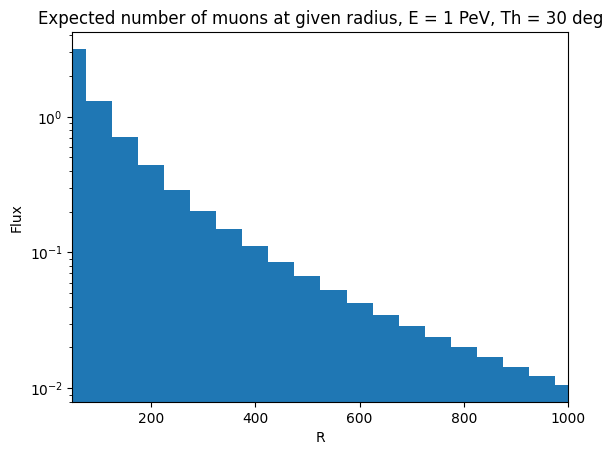

In [34]:
energy = torch.tensor([2.], requires_grad = True)
theta = torch.tensor([np.pi / 6], requires_grad = True)
R = torch.tensor(np.linspace(50, 1000, 20), requires_grad = True)
fluxes = []

for r in R:
    fluxes.append(ShowerContent(energy, theta, r, "mg").item())

plt.bar(R.detach().numpy(), fluxes, width = 50)
plt.yscale('log')
plt.ylabel("Flux")
plt.xlabel("R")
plt.title("Expected number of muons at given radius, E = 1 PeV, Th = 30 deg")
plt.xlim((50, 1000))
plt.show()

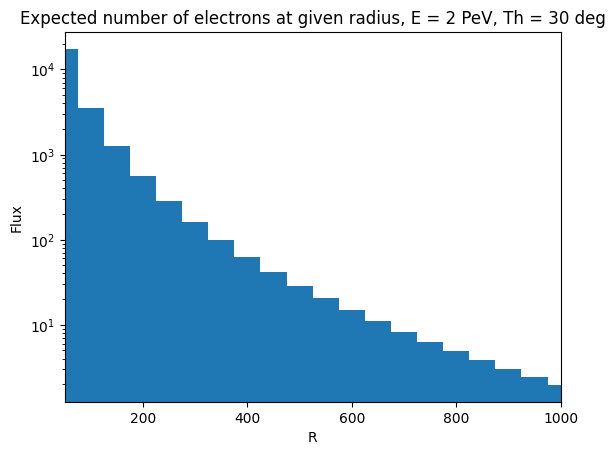

In [42]:
energy = torch.tensor([2.], requires_grad = True)
theta = torch.tensor([np.pi / 6], requires_grad = True)
R = torch.tensor(np.linspace(50, 1000, 20), requires_grad = True)
fluxes = []

for r in R:
    fluxes.append(ShowerContent(energy, theta, r, "eg").item())

plt.bar(R.detach().numpy(), fluxes, width = 50)
plt.yscale('log')
plt.ylabel("Flux")
plt.xlabel("R")
plt.title("Expected number of electrons at given radius, E = 2 PeV, Th = 30 deg")
plt.xlim((50, 1000))
plt.show()

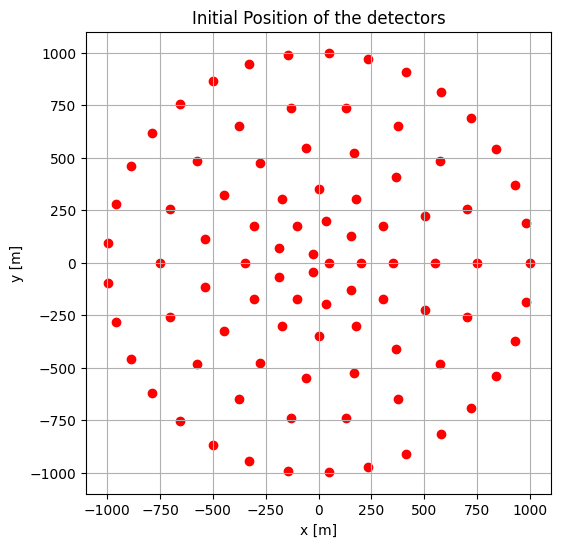

In [43]:
plt.figure(figsize = [6, 6])
plt.scatter(x.detach(), y.detach(), color = "red")
plt.grid()
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Initial Position of the detectors")
plt.xlim((-1100, 1100))
plt.ylim((-1100, 1100))
plt.show()

In [73]:
SWGOopt = False

N, T, x0, y0, E, th, ph = GenerateShowers(x, y)

Energy = 5.475 PeV
Angle = 38.3 degree


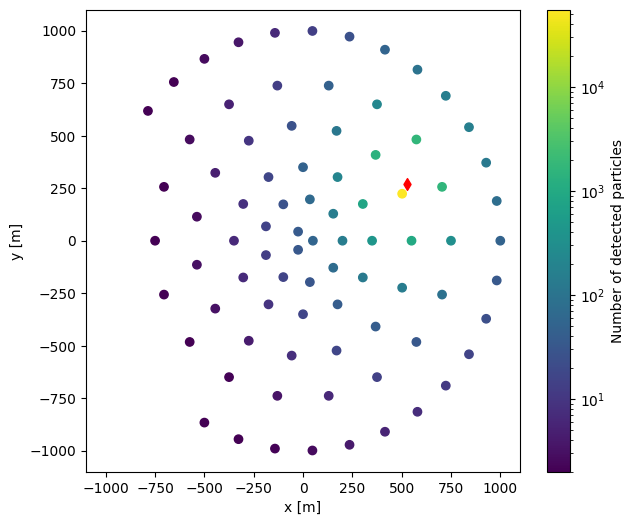

In [74]:
print(f"Energy = {E.item():.3f} PeV")
print(f"Angle = {th.item() * 180 / np.pi:.1f} degree")

idx = torch.where(N >= 1)[0]
norm = LogNorm(vmin = 2, vmax = torch.max(N).item())

plt.figure(figsize = [7, 6])
scatter = plt.scatter(x[idx], y[idx], c = N[idx], cmap = "viridis", norm = norm)
plt.colorbar(scatter, label='Number of detected particles')
plt.scatter(x0.item(), y0.item(), c = "red", marker = "d")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.xlim((-1100, 1100))
plt.ylim((-1100, 1100))
plt.show()

Angle = 38.3 degree
Phi = 87.9 degree


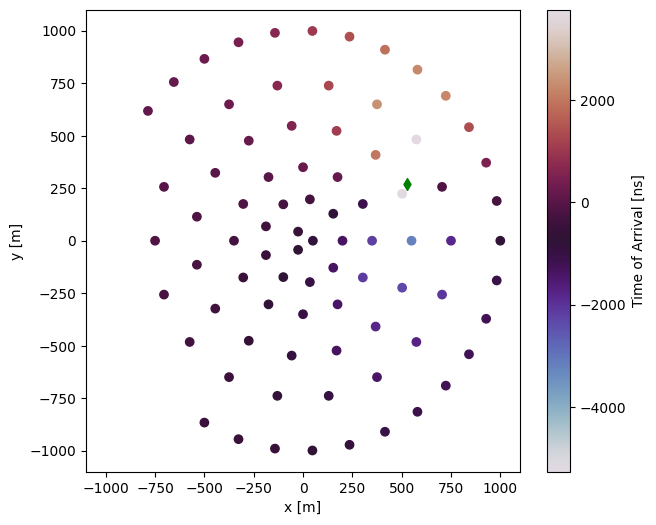

In [75]:
print(f"Angle = {th.item() * 180 / np.pi:.1f} degree")
print(f"Phi = {ph.item() * 180 / np.pi:.1f} degree")

norm = Normalize(vmin = torch.min(T), vmax = torch.max(T))

idx = torch.where(N >= 1)[0]
plt.figure(figsize = [7, 6])
scatter = plt.scatter(x[idx], y[idx], c = T[idx], cmap = "twilight", norm = norm)
plt.colorbar(scatter, label='Time of Arrival [ns]')
plt.scatter(x0.item(), y0.item(), c = "green", marker = "d")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.xlim((-1100, 1100))
plt.ylim((-1100, 1100))
plt.show()

## Training the Network

We first need some simulations to train our neural network. In the global variables part, you will find a variable num_events, which is set to 10000. We will use this number to generate random events.

### Test Data Generation

Number of showers in the test set = 100k

In [44]:
%%time

inputs = torch.zeros((Nevents, Nunits, 4))
labels = torch.zeros((Nevents, 5))

for i in range(Nevents):
    N, T, x0, y0, E, theta, phi = GenerateShowers(x, y)

    #Normalize the Labels:
    E_norm, theta_norm, phi_norm = NormalizeLabels(E, theta, phi)
    x0 = x0 / 5000 #[km]
    y0 = y0 / 5000 #[km]

    input_vector = np.column_stack((x, y, N, T))

    inputs[i] = torch.tensor(input_vector, dtype = torch.float32)
    labels[i] = torch.tensor([x0, y0, E_norm, theta_norm, phi_norm], dtype = torch.float32)

    if (i + 1) % 10000 == 0:
        print(f"Shower generation is {int((i + 1) / 1000)}% done")

torch.save(inputs, "./NN_Files/inputs.pt")
torch.save(labels, "./NN_Files/labels.pt")

Shower generation is 10% done
Shower generation is 20% done
Shower generation is 30% done
Shower generation is 40% done
Shower generation is 50% done
Shower generation is 60% done
Shower generation is 70% done
Shower generation is 80% done
Shower generation is 90% done
Shower generation is 100% done
CPU times: user 4h 43min 4s, sys: 22.6 s, total: 4h 43min 27s
Wall time: 4h 59min 10s


### Validation Set Data Generation

Number of events in the validation set = 10k, i.e 10% of the training set

In [45]:
%%time

inputs_val = torch.zeros((Nvalidation, Nunits, 4))
labels_val = torch.zeros((Nvalidation, 5))

for i in range(Nvalidation):
    N, T, x0, y0, E, theta, phi = GenerateShowers(x, y)

    #Normalize the Labels:
    E_norm, theta_norm, phi_norm = NormalizeLabels(E, theta, phi)
    x0 = x0 / 5000 #[km]
    y0 = y0 / 5000 #[km]

    input_vector = np.column_stack((x, y, N, T))

    inputs_val[i] = torch.tensor(input_vector, dtype = torch.float32)
    labels_val[i] = torch.tensor([x0, y0, E_norm, theta_norm, phi_norm], dtype = torch.float32)

    if (i + 1) % 500 == 0:
        print(f"Shower generation is {int((i + 1) / 50)}% done")

torch.save(inputs_val, "./NN_files/inputs_val.pt")
torch.save(labels_val, "./NN_files/labels_val.pt")

Shower generation is 10% done
Shower generation is 20% done
Shower generation is 30% done
Shower generation is 40% done
Shower generation is 50% done
Shower generation is 60% done
Shower generation is 70% done
Shower generation is 80% done
Shower generation is 90% done
Shower generation is 100% done
Shower generation is 110% done
Shower generation is 120% done
Shower generation is 130% done
Shower generation is 140% done
Shower generation is 150% done
Shower generation is 160% done
Shower generation is 170% done
Shower generation is 180% done
Shower generation is 190% done
Shower generation is 200% done
CPU times: user 27min 29s, sys: 1.38 s, total: 27min 30s
Wall time: 27min 31s


### Load the Sets

In [23]:
inputs = torch.load("./NN_Files/inputs.pt")
labels = torch.load("./NN_Files/labels.pt")

inputs_val = torch.load("./NN_Files/inputs_val.pt")
labels_val = torch.load("./NN_Files/labels_val.pt")

### Model

In [53]:
#In this part we are defining our model, which is the Neural network for our reconstruction
#We will use Mean Square Error Loss
#Optimization model is SGD, to keep consistent with our next steps

model = Reconstruction()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-5)

In [54]:
dataset = TensorDataset(inputs, labels)

dataloader = DataLoader(dataset, batch_size = 256, shuffle = True, drop_last = True, num_workers = 4)

Training is 10% done, with Loss = 0.06
Training is 20% done, with Loss = 0.05
Training is 30% done, with Loss = 0.04
Early stop at epoch 300
Validation loss = 0.04
Training loss = 0.03
CPU times: user 58min 33s, sys: 3min 24s, total: 1h 1min 58s
Wall time: 40min 54s


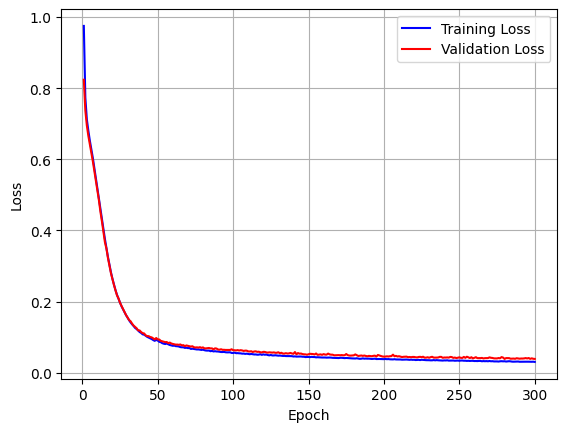

In [55]:
%%time

val_losses = []
losses = []

early_stopper = EarlyStopping()

for num_epoch in range(1000):

    epoch_loss = 0
    total_batch = 0
    
    for batch_inputs, batch_labels in dataloader:
        batch_size = batch_inputs.size(0)

        train_x = batch_inputs.view(batch_size, -1)
        
        train_y = batch_labels.view(batch_size, -1)
        
        #Train the network
        outputs = model(train_x)

        loss = criterion(outputs, train_y)
        epoch_loss += loss.item()
        total_batch += 1

        loss.backward()
        optimizer.step()

        optimizer.zero_grad()

    #See if our loss in our validation set improves:
    val_size = inputs_val.size(0)

    val_x = inputs_val.view(val_size, -1)
    val_y = labels_val.view(val_size, -1)

    model.eval()

    with torch.no_grad():

        val_output = model(val_x)
        val_loss = criterion(val_output, val_y)
    
    val_losses.append(val_loss.item())
    early_stopper(val_loss)

    if (num_epoch + 1) % 100 == 0:
        print(f"Training is {int((num_epoch + 1) / 10)}% done, with Loss = {val_loss:.2f}")

    losses.append(epoch_loss / total_batch)

    if early_stopper.early_stop:
        print(f"Early stop at epoch {num_epoch + 1}")
        print(f"Validation loss = {val_loss:.2f}")
        print(f"Training loss = {epoch_loss / total_batch:.2f}")
        break

plt.plot(np.arange(1, len(losses) + 1), losses, color = "blue", label = "Training Loss")
plt.plot(np.arange(1, len(val_losses) + 1), val_losses, color = "red", label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

In [42]:
E_r = []
E_p = []

X_r = []
X_p = []

Y_r = []
Y_p = []

Th_r = []
Th_p = []

Ph_r = []
Ph_p = []

for i in range(300):
    N, T, x0, y0, E, th, ph = GenerateShowers(x, y)
    X = torch.tensor(np.column_stack((x, y, N, T)), dtype = torch.float32)
    X = X.view(1, -1)

    model.eval()

    with torch.no_grad():
        output = model(X)

    x_pred = output[0, 0]
    y_pred = output[0, 1]
    E_pred = output[0, 2]

    theta_pred = output[0, 3]
    phi_pred = output[0, 4]
    E_pred, theta_pred, phi_pred = DenormalizeLabels(E_pred, theta_pred, phi_pred)
    
    E_p.append(E_pred)
    E_r.append(E.item())

    X_r.append(x0.item())
    X_p.append(x_pred * 5000)

    Y_r.append(y0.item())
    Y_p.append(y_pred * 5000)

    Th_r.append(th.item())
    Th_p.append(theta_pred)

    Ph_r.append(ph.item())
    Ph_p.append(phi_pred)

    if (i + 1) % 30 == 0:
        print(f"Predicted: {E_pred:.1f}, Real: {E.item():.1f}")

Predicted: 5.3, Real: 8.5
Predicted: 1.6, Real: 1.3
Predicted: 6.8, Real: 6.3
Predicted: 2.2, Real: 1.7
Predicted: 9.8, Real: 6.8
Predicted: 2.5, Real: 1.4
Predicted: 4.9, Real: 6.8
Predicted: 7.5, Real: 7.2
Predicted: 4.5, Real: 4.7
Predicted: 2.0, Real: 1.1


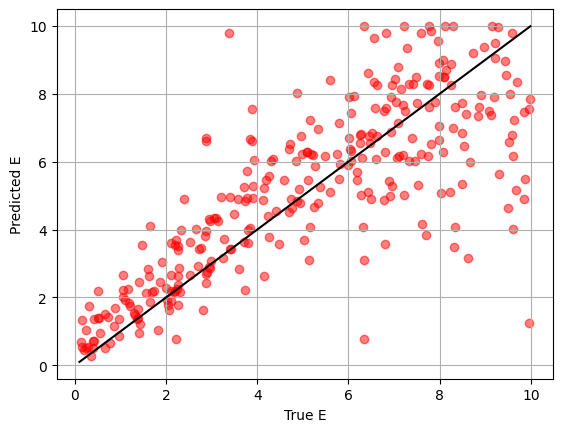

In [43]:
plt.scatter(E_r, E_p, alpha = .5, color = "red")
plt.plot(np.arange(.1, 10, .01), np.arange(.1, 10, .01), color = "black")
plt.xlabel("True E")
plt.ylabel("Predicted E")
plt.grid()

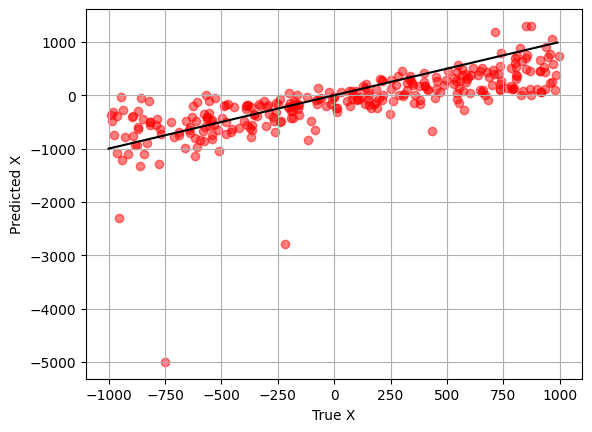

In [44]:
plt.scatter(X_r, X_p, alpha = .5, color = "red")
plt.plot(np.arange(-1000, 1000, 10), np.arange(-1000, 1000, 10), color = "black")
plt.xlabel("True X")
plt.ylabel("Predicted X")
plt.grid()

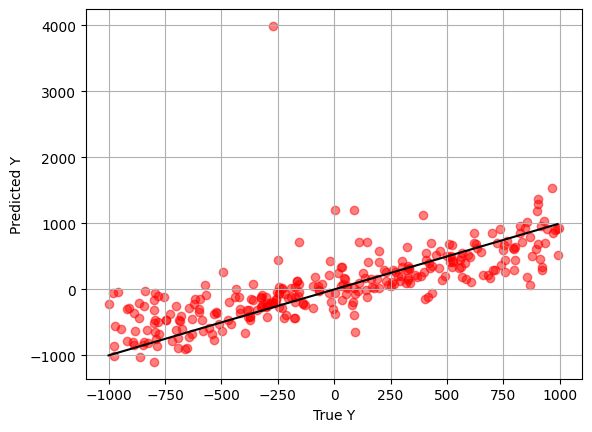

In [45]:
plt.scatter(Y_r, Y_p, alpha = .5, color = "red")
plt.plot(np.arange(-1000, 1000, 10), np.arange(-1000, 1000, 10), color = "black")
plt.xlabel("True Y")
plt.ylabel("Predicted Y")
plt.grid()

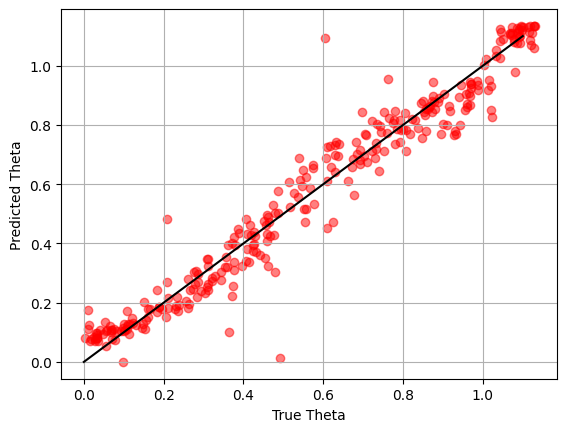

In [46]:
plt.scatter(Th_r, Th_p, alpha = .5, color = "red")
plt.plot(np.arange(0, np.pi * 65 / 180, .1), np.arange(0, np.pi * 65 / 180, .1), color = "black")
plt.xlabel("True Theta")
plt.ylabel("Predicted Theta")
plt.grid()

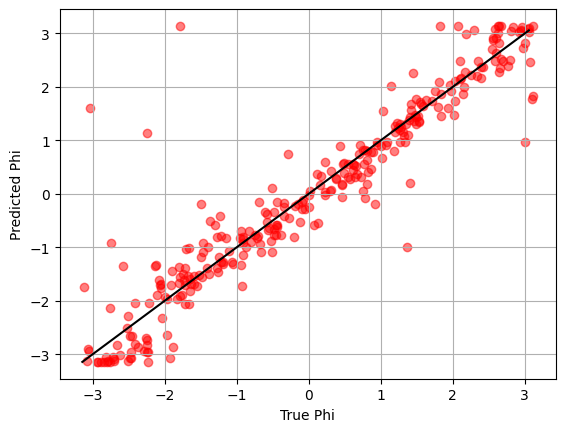

In [47]:
plt.scatter(Ph_r, Ph_p, alpha = .5, color = "red")
plt.plot(np.arange(- np.pi, np.pi, .1), np.arange(- np.pi, np.pi, .1), color = "black")
plt.xlabel("True Phi")
plt.ylabel("Predicted Phi")
plt.grid()

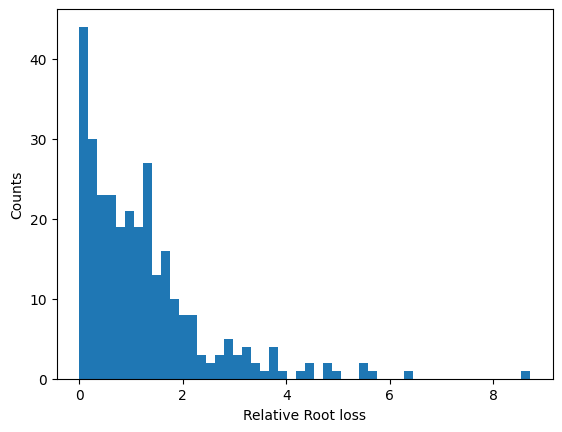

In [48]:
plt.hist(np.sqrt((np.array(E_p) - np.array(E_r)) ** 2), bins = 50)
plt.xlabel("Relative Root loss")
plt.ylabel("Counts")
plt.show()

## Optimization

This is part where we start moving our arrays according to Utility Function.

You can check the utilities that we use above and see that it is > 0

So we will use -U as a "loss" function and minimize it, so that we can maximize our value

In [33]:
#First save the weights or load them so that we don't have to train the network every time we start the kernel
#Remove the commend operator "#" if you want to save

#torch.save(model.state_dict(), './NN_files/model_weights.pth')

model = Reconstruction()

path = Path("./NN_Files/checkpoint.pth")

if path.exists():
    checkpoint = torch.load('./NN_Files/checkpoint.pth')

    model.load_state_dict(checkpoint['model_state_dict'])
    print("Updated Weights are loaded")
    
else:
    model.load_state_dict(torch.load('./NN_files/model_weights.pth'))
    print("Initial Weights are loaded")

Updated Weights are loaded


In [34]:
def barycentric_coords(P, A, B, C):
    """
    Compute barycentric coordinates for each point P with respect to triangle ABC.
    P: Tensor of shape (N, 2)
    A, B, C: Tensors of shape (2,)
    """
    v0 = C - A
    v1 = B - A
    v2 = P - A

    d00 = v0 @ v0
    d01 = v0 @ v1
    d11 = v1 @ v1
    d20 = torch.sum(v2 * v0, dim=1)
    d21 = torch.sum(v2 * v1, dim=1)

    denom = d00 * d11 - d01 * d01 + 1e-8
    u = (d11 * d20 - d01 * d21) / denom
    v = (d00 * d21 - d01 * d20) / denom
    return u, v

In [35]:
def project_to_triangle(x, y):
    """
    Projects each (x[i], y[i]) point inside the triangle defined by:
    A = (-3200, 2000), B = (1800, 2000), C = (1800, -3600)
    x, y: tensors of shape (N,)
    Returns: projected x and y, tensors of shape (N,)
    """
    A = torch.tensor([-3800.0, 1500.0], device=x.device)
    B = torch.tensor([1200.0, 1500.0], device=x.device)
    C = torch.tensor([1200.0, -4100.0], device=x.device)

    P = torch.stack([x, y], dim=1)  # (N, 2)

    # Compute barycentric coordinates
    u, v = barycentric_coords(P, A, B, C)

    # Determine which points are inside the triangle
    inside = (u >= 0) & (v >= 0) & (u + v <= 1)

    # Clip to triangle: u, v ∈ [0, 1], u + v ≤ 1
    u_clipped = torch.clamp(u, 0.0, 1.0)
    v_clipped = torch.clamp(v, 0.0, 1.0)
    uv_sum = u_clipped + v_clipped
    over = uv_sum > 1.0
    u_clipped[over] = u_clipped[over] / uv_sum[over]
    v_clipped[over] = v_clipped[over] / uv_sum[over]

    v0 = C - A
    v1 = B - A
    P_proj = A + u_clipped.unsqueeze(1) * v0 + v_clipped.unsqueeze(1) * v1

    # If already inside, keep P. Otherwise, use projection.
    final_P = torch.where(inside.unsqueeze(1), P, P_proj)

    return final_P[:, 0], final_P[:, 1]  # x_proj, y_proj

In [36]:
e = 0

for i in range(1000):
    p_layout = Path(f"./Python_Layouts/Layout_{i + 1}.txt")
    
    if p_layout.exists():
        data = np.loadtxt(p_layout)
        
        x = torch.tensor(data[:, 0], dtype = torch.float32)
        y = torch.tensor(data[:, 1], dtype = torch.float32)
        e = i + 1

if e > 0:
    print(f"Updated Layout {e} is initialized")

else:
    print("First Layout is initialized")

class LearnableXY(torch.nn.Module):
    def __init__(self, x_init, y_init):
        super().__init__()
        self.x = torch.nn.Parameter(x_init)
        self.y = torch.nn.Parameter(y_init)

    def forward(self):
        return self.x, self.y

xy_module = LearnableXY(x, y)

Updated Layout 200 is initialized


In [37]:
def push_apart(module, min_dist = 2 * TankRadius):
    x, y = module()  # Correctly calls forward()
    coords = torch.stack([x, y], dim=1)  # shape (N, 2)

    with torch.no_grad():
        for i in range(coords.shape[0]):
            diffs = coords[i] - coords
            dists = torch.norm(diffs, dim=1)
            mask = (dists < min_dist) & (dists > 0)

            for j in torch.where(mask)[0]:
                direction = diffs[j] / dists[j]
                displacement = 0.5 * (min_dist - dists[j]) * direction
                coords[i] += displacement
                coords[j] -= displacement

        # Update learnable parameters in-place
        module.x.data.copy_(coords[:, 0])
        module.y.data.copy_(coords[:, 1])

In [38]:
%%time

#Now we do the optimization step
SWGOopt = True
optimizer = torch.optim.SGD(xy_module.parameters(), lr = 50, momentum = .9)

if path.exists():
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    num_epoch = checkpoint.get("epoch") + 1
    loss = checkpoint.get("loss")
    
    print(f"Optimizer is initialized from the last epoch {num_epoch}")

else:
    num_epoch = 0
    print("Optimizer is initialized")

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.9)
max_grad = 10.

Nbatch = 500

if num_epoch < 20:
    Nfinetune = 2500

elif num_epoch >= 20:
    Nfinetune = 5000

U_vals = []
U_pr_vals = []
U_e_vals = []
U_th_vals = []

for epoch in range(num_epoch, num_epoch + 100):
    x1, y1 = xy_module()

    groups = group_indices_by_rotation(x1, y1, n_symmetry = 3)
    
    #Batch Generation:
    N_list = []
    T_list = []
    labels_batch = torch.zeros((Nbatch, 5))
    
    for i in range(Nbatch):
        N, T, x0, y0, E, theta, phi = GenerateShowers(x1, y1)

        N_list.append(N)
        T_list.append(T)
        labels_batch[i] = torch.tensor([x0, y0, E, theta, phi], dtype = torch.float32)
    
    x = x1.unsqueeze(0).repeat(Nbatch, 1)
    y = y1.unsqueeze(0).repeat(Nbatch, 1)

    events_n_batch = torch.stack(N_list).squeeze(-1)  # shape: (Nbatch, Nunits)
    events_t_batch = torch.stack(T_list).squeeze(-1)
    
    events_batch = torch.stack((x, y, events_n_batch, events_t_batch), dim = 2)
    
    model.eval()

    preds_batch = model(events_batch.view(Nbatch, -1))

    #Denormalize the predictions
    preds_x = preds_batch[:, 0] * 5000
    preds_y = preds_batch[:, 1] * 5000
    preds_e, preds_th, preds_phi = DenormalizeLabels(preds_batch[:, 2], preds_batch[:, 3], 
                                                                                preds_batch[:, 4])

    #Compute the reconstructability score for each event:
    r_score = reconstructability(events_batch[:, :, 2])
    density = Nbatch / ((labels_batch[:, 0].max() - labels_batch[:, 0].min()) * 
                        (labels_batch[:, 1].max() - labels_batch[:, 1].min()))

    #Compute Utility:
    U = U_PR(r_score) / torch.sqrt(density) #+ U_E(preds_e, labels_batch[:, 2], r_score) + 1e-2 * U_TH(preds_th, labels_batch[:, 3], r_score)
    print(f"Utility = {U.item():.2f}")

    #Save the utility values to plot
    U_vals.append(U.item())
    """
    U_pr_vals.append((U_PR(r_score) / torch.sqrt(density)).item())
    U_e_vals.append(U_E(preds_e, labels_batch[:, 2], r_score).item())
    U_th_vals.append(1e-2 * U_TH(preds_th, labels_batch[:, 3], r_score).item())
    """

    #Use utility as - Loss
    Loss = - U

    Loss.backward()

    torch.nn.utils.clip_grad_norm_(xy_module.parameters(), max_norm = max_grad)
    #enforce_symmetric_gradients(xy_module, groups)

    optimizer.step()

    with torch.no_grad():
        push_apart(xy_module)
    
    #scheduler.step()

    #This part is done to keep the detectors inside the layout
    """
    with torch.no_grad():
        x_proj, y_proj = project_to_triangle(x1.view(-1), y1.view(-1))
        x1.copy_(x_proj)
        y1.copy_(y_proj)
    """
    
    optimizer.zero_grad()

    #Now we need to generate new events that with the new layout so that we can fine tune our NN when it's necessary
    if (epoch + 1) % 5000 == 0:
        print(f"Fine Tune at epoch {epoch + 1}")
        
        finetune_events = torch.zeros((Nfinetune, Nunits, 4))
        finetune_trues = torch.zeros((Nfinetune, 5))

        with torch.no_grad():
            x2, y2 = xy_module()
            x = x2.detach()
            y = y2.detach()

            #Generate events to fine tune the network
            for i in range(Nfinetune):
                N, T, x0, y0, E, theta, phi = GenerateShowers(x, y)
            
                x0 /= 5000
                y0 /= 5000
                E, theta, phi = NormalizeLabels(E, theta, phi)

                finetune_events[i] = torch.tensor(np.column_stack((x, y, N, T)))
                finetune_trues[i] = torch.tensor([x0, y0, E, theta, phi], dtype = torch.float32)

        ReconstructionNN = model
        ReconstructionNN.train()
        criterion = nn.MSELoss()
        optimizerNN = torch.optim.Adam(ReconstructionNN.parameters(), lr = 5e-5)

        dataset = TensorDataset(finetune_events, finetune_trues)
        dataloader = DataLoader(dataset, batch_size = 32, shuffle = True, drop_last = True, num_workers = 4)

        for j in range(5):
            for ft_batch, ft_trues in dataloader:
                batch_size = ft_batch.size(0)

                train_x = ft_batch.view(batch_size, -1)
        
                train_y = ft_trues.view(batch_size, 5)
        
                #Train the network
                outputs = ReconstructionNN(train_x)

                lossT = criterion(outputs, train_y)

                lossT.backward()
                optimizerNN.step()

                optimizerNN.zero_grad()

    #I will save the layouts and weights here so that I can stop whenever and continue later
    torch.save({"epoch": epoch, "loss": Loss, "model_state_dict": model.state_dict(), 
                "optimizer_state_dict": optimizer.state_dict()}, "./NN_Files/checkpoint.pth")
    
    np.savetxt(f"./Python_Layouts/Layout_{epoch + 1}.txt", np.column_stack((x1.detach().numpy(), y1.detach().numpy())))

Optimizer is initialized from the last epoch 200
Utility = 2875.97
Utility = 3058.43
Utility = 2836.77
Utility = 3086.13
Utility = 2876.30
Utility = 2893.16
Utility = 2889.64
Utility = 2824.36
Utility = 2812.94
Utility = 2962.05
Utility = 2910.93
Utility = 2993.64
Utility = 2908.29
Utility = 2821.65
Utility = 2817.80
Utility = 3185.13
Utility = 2661.44
Utility = 2925.95
Utility = 2762.35
Utility = 2812.65
Utility = 2908.19
Utility = 2784.63
Utility = 2914.54
Utility = 2965.96
Utility = 2692.72
Utility = 2880.54
Utility = 2917.42
Utility = 2865.15
Utility = 2963.77
Utility = 2973.74
Utility = 2830.94
Utility = 2940.17
Utility = 2954.78
Utility = 3010.40
Utility = 2895.84
Utility = 2788.38
Utility = 2960.03
Utility = 3085.62
Utility = 2845.14
Utility = 2971.39
Utility = 3172.36
Utility = 3047.45
Utility = 2998.73
Utility = 2933.26
Utility = 3048.43
Utility = 3008.97
Utility = 2942.06
Utility = 2872.30
Utility = 3254.75
Utility = 2929.10
Utility = 2938.92
Utility = 2924.81
Utility = 2927.

KeyboardInterrupt: 

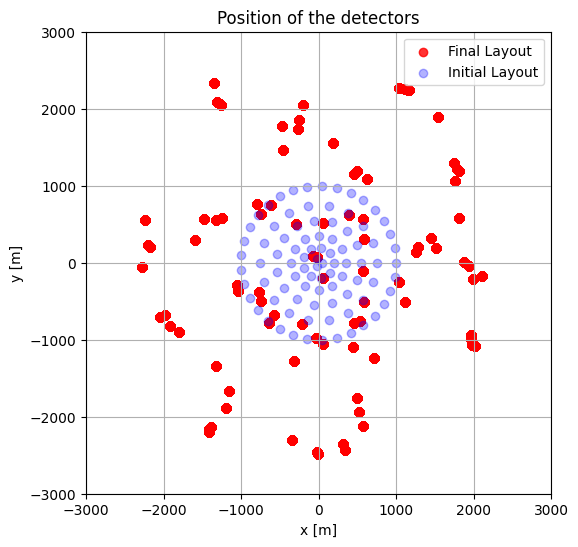

In [40]:
a, b = Layouts()

plt.figure(figsize = [6, 6])
plt.scatter(x.detach(), y.detach(), color = "red", alpha = .8, label = "Final Layout")
plt.scatter(a, b, color = "blue", alpha = .3, label = "Initial Layout")
#plt.plot([-3800, 1200, 1200, -3800], [1500, 1500, -4100, 1500], "k--", label = "SWGO Site")

#Add Shower Simulation Area
#ax = plt.gca()
#rect = patches.Rectangle((-3000, -3000), 6000, 6000, linewidth=1.5, edgecolor='green', facecolor='green',
                         #alpha=0.1, label='Shower Simulation Area')
#ax.add_patch(rect)

plt.grid()
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("Position of the detectors")
plt.legend()
plt.xlim((-3000, 3000))
plt.ylim((-3000, 3000))
plt.show()

In [41]:
utility_path = Path("./Python_Layouts/Utilities.txt")

if utility_path.exists():
    data = np.loadtxt(utility_path)
    u_t = data
    #u_p = data[:, 1]
    #u_e = data[:, 2]
    #u_a = data[:, 3]

    u_t = np.append(u_t, np.array(U_vals).ravel())
    #u_p = np.append(u_p, np.array(U_pr_vals).ravel())
    #u_e = np.append(u_e, np.array(U_e_vals).ravel())
    #u_a = np.append(u_a, np.array(U_th_vals).ravel())

    #data = np.column_stack((u_t, u_p, u_e, u_a))

    np.savetxt(utility_path, u_t)
    
else:
    u_t = U_vals
    #u_p = U_pr_vals
    #u_e = U_e_vals
    #u_a = U_th_vals
    
    #data = np.column_stack((u_t, u_p, u_e, u_a))
    np.savetxt(utility_path, u_t)

In [43]:
mean_ut = [np.mean(u_t[i - 4: i]) for i in range(4, len(u_t))]

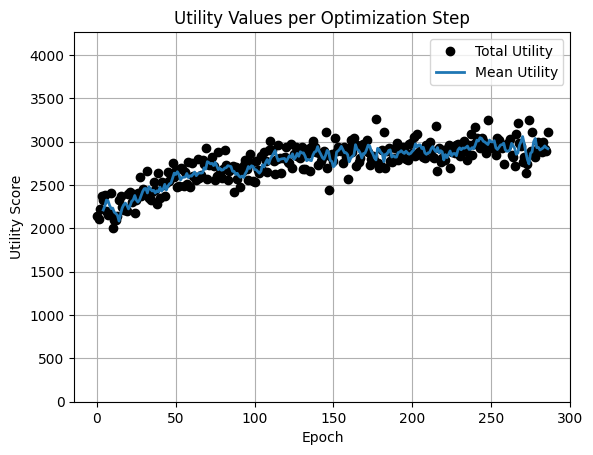

In [47]:
plt.plot(u_t, color = "black", linestyle = "none", marker = "o", linewidth = .5, label = "Total Utility")
plt.plot(np.arange(4, len(u_t)), mean_ut, linestyle = "-", linewidth = 2, label = "Mean Utility")
#plt.plot(u_p, color = "orange", linestyle = "-.", label = "Reconstructability Utility")
#plt.plot(u_e, color = "green", linestyle = "-.", label = "Energy Utility")
#plt.plot(u_a, color = "purple", linestyle = "-.", label = "Angle Utility")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Utility Score")
plt.ylim((0, np.max(u_t) + 1000))
plt.title("Utility Values per Optimization Step")
plt.show()